In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import os
import numpy as np

# # Charger les annotations Ground Truth (GT)
# gt_path = "../dataset_esprit_24_02/annotations/person_keypoints_default.json"  # Remplace avec ton chemin
# coco_gt = COCO(gt_path)

# # Charger le fichier GT qui est actuellement mal formaté comme un fichier prédictions
# pd_path = "../runs/pose/predict4/val_keypoints.json"
# with open(pd_path, "r") as f:
#     pd_data = json.load(f)

# # Vérifier que la structure est bien celle d'un GT COCO
# if "annotations" not in pd_data:
#     raise ValueError("Le fichier semble être au format prédictions déjà.")

# # Extraire uniquement les annotations et les convertir au format prédictions
# coco_results = []
# for ann in pd_data["annotations"]:  # Accéder aux annotations GT
#     coco_results.append({
#         "image_id": ann["image_id"],
#         "category_id": ann["category_id"],
#         "keypoints": ann["keypoints"],  # Assurez-vous d'avoir [x, y, visibility]
#         "score": 0.9  # Ajouter un score par défaut
#     })

# # Sauvegarde au format prédictions
# pred_path = "../runs/pose/predict4/fixed_val_keypoints.json"
# with open(pred_path, "w") as f:
#     json.dump(coco_results, f, indent=4)


# # Vérifier les image_id du GT et des prédictions
# gt_image_ids = set(coco_gt.getImgIds())  # ID des images dans le GT
# with open(pred_path, "r") as f:
#     pred_data = json.load(f)
# pred_image_ids = set([ann["image_id"] for ann in pred_data])  # ID dans les prédictions

# # Afficher la différence
# missing_ids = pred_image_ids - gt_image_ids  # Images présentes en prédictions mais absentes du GT
# if missing_ids:
#     print(f"⚠️ Erreur : {len(missing_ids)} image_id dans les prédictions ne sont pas dans le GT !")
#     print("Exemples :", list(missing_ids)[:5])  # Affiche quelques erreurs
# else:
#     print("✅ Tous les image_id sont corrects")


# # Charger le fichier prédictions correctement
# coco_gt = COCO("../dataset_esprit_24_02/annotations/person_keypoints_default.json")  # Fichier GT d'origine
# coco_dt = coco_gt.loadRes(pred_path)

# print(f"Fichier de prédictions sauvegardé et chargé avec COCO : {pred_path}")



In [2]:
%matplotlib inline

In [39]:
from ultralytics.data.converter import convert_coco

# Convertir COCO en YOLO format avec keypoints
convert_coco(labels_dir="./yolo_predictions.json", save_dir="./yolo_gt_labels", use_keypoints=True)

print("✅ Conversion terminée : annotations YOLO enregistrées dans './yolo_gt_labels'")

COCO data converted successfully.
Results saved to C:\Users\mougi\Documents\Spash\testing\yolo_gt_labels
✅ Conversion terminée : annotations YOLO enregistrées dans './yolo_gt_labels'


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


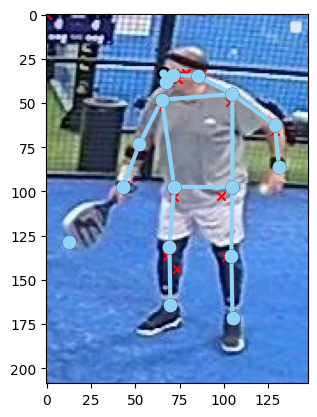

In [3]:
import matplotlib.pyplot as plt
import os
import random

# Charger le Ground Truth
coco_gt = COCO("./groundtruth/groundtruth.json")

def visualize_keypoints(image_id, yolo_labels_dir):
    img_info = coco_gt.loadImgs(image_id)[0]
    img_path = os.path.join("./images/default/", img_info["file_name"])  # Modifier selon le dataset
    plt.imshow(plt.imread(img_path))

    # Afficher les keypoints du GT
    ann_ids = coco_gt.getAnnIds(imgIds=image_id)
    anns = coco_gt.loadAnns(ann_ids)
    coco_gt.showAnns(anns)

    # Afficher les keypoints YOLO
    yolo_file = os.path.join(yolo_labels_dir, img_info["file_name"].replace(".jpg", ".txt"))
    if os.path.exists(yolo_file):
        with open(yolo_file, "r") as f:
            yolo_data = f.readlines()

        for line in yolo_data:
            values = list(map(float, line.strip().split()))
            keypoints = values[2:]  # Ignorer class_id et bbox
            width, height = img_info["width"], img_info["height"]

            for i in range(17):  # 17 keypoints en YOLO
                x = keypoints[i * 3] * width
                y = keypoints[i * 3 + 1] * height
                plt.scatter(x, y, color="red", marker="x")

    plt.legend()
    plt.show()

# Sélectionne une image au hasard pour vérifier

# random_image_id = random.choice(coco_gt.getImgIds())
visualize_keypoints(15, "./yolo_labels")


In [4]:
def yolo_to_coco_results(yolo_labels_dir, groundtruth_path, output_coco_results):
    """
    Convertit les prédictions YOLO en format de résultats COCO pour l'évaluation avec pycocotools.
    
    Arguments:
        yolo_labels_dir (str): Dossier contenant les fichiers de prédictions YOLO (.txt).
        groundtruth_path (str): Fichier JSON COCO des annotations ground truth.
        output_coco_results (str): Chemin du fichier JSON de sortie en format COCO.
    """
    
    # Charger les annotations Ground Truth COCO pour récupérer les image_id
    with open(groundtruth_path, "r") as f:
        coco_gt = json.load(f)

    # Associer les noms de fichiers aux image_id COCO
    image_id_map = {img["file_name"]: img["id"] for img in coco_gt["images"]}
    
    # Liste pour stocker les résultats COCO
    coco_results = []

    # Parcourir les fichiers de prédictions YOLO
    for filename in os.listdir(yolo_labels_dir):
        if not filename.endswith(".txt"):
            continue  
        
        image_name = filename.replace(".txt", ".jpg")  # Adapter selon le format d'image
        if image_name not in image_id_map:
            print(f"⚠️ Image {image_name} ignorée (pas trouvée dans le GT).")
            continue
        
        image_id = image_id_map[image_name]
        file_path = os.path.join(yolo_labels_dir, filename)

        # Lire le fichier YOLO (chaque ligne = une prédiction)
        with open(file_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = line.strip().split()
            if len(values) < 2 + 3 * 17:  # 1 class_id + 2 bbox + 3 * 17 keypoints
                print(f"⚠️ Ligne ignorée dans {filename}, format incorrect")
                continue

            class_id = int(values[0])  # ID de la catégorie (ex: 0 pour 'person')
            keypoints = list(map(float, values[2:]))  # Conversion des keypoints en float

            # YOLO stocke les coordonnées normalisées (entre 0 et 1)
            # COCO attend des coordonnées absolues en pixels.
            keypoints_abs = []
            # Créer un dictionnaire {image_id: {"width": ..., "height": ...}}
            image_info_map = {img["id"]: img for img in coco_gt["images"]}

            # Vérifier que l'image_id existe dans le dictionnaire
            if image_id not in image_info_map:
                print(f"⚠️ Erreur : image_id {image_id} non trouvé dans le fichier COCO GT.")
                continue  # Passe à l'image suivante

            # Maintenant, on peut accéder aux dimensions correctement
            width, height = image_info_map[image_id]["width"], image_info_map[image_id]["height"]

            for i in range(17):  # 17 keypoints
                x = keypoints[i * 3] * width
                y = keypoints[i * 3 + 1] * height
                visibility = int(round(keypoints[i * 3 + 2]*2))  # Normalement 0 ou 1 en YOLO donc x2 pour etre 0 ou 2
                keypoints_abs.extend([x, y, visibility])

            # Ajouter au format COCO
            coco_results.append({
                "image_id": image_id,
                "category_id": class_id + 1,  # Adapter selon le dataset
                "keypoints": keypoints_abs,
                "score": 0.9  # Score par défaut (YOLO peut avoir un score en fin de ligne)
            })

    # Sauvegarde des résultats COCO
    with open(output_coco_results, "w") as f:
        json.dump(coco_results, f, indent=4)

    print(f"✅ Fichier COCO généré : {output_coco_results}")

# Exécuter la fonction
yolo_labels_dir = "./yolo_labels"
groundtruth_path = "./groundtruth/groundtruth.json"
output_coco_results = "./yolo_predictions_coco.json"

yolo_to_coco_results(yolo_labels_dir, groundtruth_path, output_coco_results)


✅ Fichier COCO généré : ./yolo_predictions_coco.json


# Avec remapping

In [5]:
import os
import json

def yolo_to_coco_results(yolo_labels_dir, groundtruth_path, output_coco_results):
    """
    Convertit les prédictions YOLO en format de résultats COCO pour l'évaluation avec pycocotools,
    en réorganisant les keypoints selon l'ordre correct.

    Arguments:
        yolo_labels_dir (str): Dossier contenant les fichiers de prédictions YOLO (.txt).
        groundtruth_path (str): Fichier JSON COCO des annotations ground truth.
        output_coco_results (str): Chemin du fichier JSON de sortie en format COCO.
    """
    
    # Charger les annotations Ground Truth COCO pour récupérer les image_id
    with open(groundtruth_path, "r") as f:
        coco_gt = json.load(f)

    # Associer les noms de fichiers aux image_id COCO
    image_id_map = {img["file_name"]: img["id"] for img in coco_gt["images"]}
    
    # Liste pour stocker les résultats COCO
    coco_results = []

    # Définir l'ordre correct des keypoints YOLO → COCO
    # yolo_to_coco_mapping = [4, 2, 3, 1, 6, 7, 8, 11, 10, 9, 12, 13, 14, 15, 16, 0, 5]
    yolo_to_coco_mapping = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


    # Parcourir les fichiers de prédictions YOLO
    for filename in os.listdir(yolo_labels_dir):
        if not filename.endswith(".txt"):
            continue  
        
        image_name = filename.replace(".txt", ".jpg")  # Adapter selon le format d'image
        if image_name not in image_id_map:
            print(f"⚠️ Image {image_name} ignorée (pas trouvée dans le GT).")
            continue
        
        image_id = image_id_map[image_name]
        file_path = os.path.join(yolo_labels_dir, filename)

        # Lire le fichier YOLO (chaque ligne = une prédiction)
        with open(file_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            values = line.strip().split()
            if len(values) < 2 + 3 * 17:  # 1 class_id + 2 bbox + 3 * 17 keypoints
                print(f"⚠️ Ligne ignorée dans {filename}, format incorrect")
                continue

            class_id = int(values[0])  # ID de la catégorie (ex: 0 pour 'person')
            keypoints = list(map(float, values[2:]))  # Conversion des keypoints en float

            # YOLO stocke les coordonnées normalisées (entre 0 et 1)
            # COCO attend des coordonnées absolues en pixels.
            keypoints_abs = []
            # Créer un dictionnaire {image_id: {"width": ..., "height": ...}}
            image_info_map = {img["id"]: img for img in coco_gt["images"]}

            # Vérifier que l'image_id existe dans le dictionnaire
            if image_id not in image_info_map:
                print(f"⚠️ Erreur : image_id {image_id} non trouvé dans le fichier COCO GT.")
                continue  # Passe à l'image suivante

            # Maintenant, on peut accéder aux dimensions correctement
            width, height = image_info_map[image_id]["width"], image_info_map[image_id]["height"]

            # Réorganiser les keypoints en respectant l'ordre de COCO
            for i in yolo_to_coco_mapping:
                x = keypoints[i * 3] * width
                y = keypoints[i * 3 + 1] * height
                visibility = int(round(keypoints[i * 3 + 2] * 2))  # Normalement 0 ou 1 en YOLO, donc x2 pour être 0 ou 2
                keypoints_abs.extend([x, y, visibility])

            # Ajouter au format COCO
            coco_results.append({
                "image_id": image_id,
                "category_id": class_id + 1,  # Adapter selon le dataset
                "keypoints": keypoints_abs,
                "score": 0.9  # Score par défaut (YOLO peut avoir un score en fin de ligne)
            })

    # Sauvegarde des résultats COCO
    with open(output_coco_results, "w") as f:
        json.dump(coco_results, f, indent=4)

    print(f"✅ Fichier COCO généré avec keypoints réorganisés : {output_coco_results}")

# Exécuter la fonction
yolo_labels_dir = "./yolo_labels"
groundtruth_path = "./groundtruth/groundtruth.json"
output_coco_results = "./yolo_predictions_coco.json"

yolo_to_coco_results(yolo_labels_dir, groundtruth_path, output_coco_results)


✅ Fichier COCO généré avec keypoints réorganisés : ./yolo_predictions_coco.json


In [6]:
# Charger le GT
coco_gt = COCO(groundtruth_path)

# Modifier le GT en mémoire avant évaluation
for ann in coco_gt.anns.values():  # coco_gt.anns contient toutes les annotations
    if len(ann["keypoints"]) == 18 * 3:
        ann["keypoints"] = ann["keypoints"][:17 * 3]  # Retire le 18e keypoint

# Charger les résultats prédits
coco_dt = coco_gt.loadRes(output_coco_results)

# Évaluation
coco_eval = COCOeval(coco_gt, coco_dt, "keypoints")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.834
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.783
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.709
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.835
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.923
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | ma

# EVALUER UNE IMAGE


In [7]:
def get_image_id_from_filename(coco_gt, image_filename):
    """
    Trouve l'image_id à partir du nom du fichier dans COCO GT.
    """
    for img in coco_gt.dataset["images"]:
        if img["file_name"] == image_filename:
            return img["id"]
    print(f"⚠️ Image '{image_filename}' non trouvée dans COCO GT.")
    return None  # Si non trouvé


In [8]:
# Charger le GT et les résultats
groundtruth_path = "./groundtruth/groundtruth.json"
predictions_path = "./yolo_predictions_coco.json"

coco_gt = COCO(groundtruth_path)
# Modifier le GT en mémoire avant évaluation
for ann in coco_gt.anns.values():  # coco_gt.anns contient toutes les annotations
    if len(ann["keypoints"]) == 18 * 3:
        ann["keypoints"] = ann["keypoints"][:17 * 3]  # Retire le 18e keypoint
coco_dt = coco_gt.loadRes(predictions_path)

# 🔹 Définir le fichier image à tester
image_filename = "frame_600_crop_1.jpg"  

# Récupérer l'ID de l'image
image_id = get_image_id_from_filename(coco_gt, image_filename)
if image_id is not None:
    # Lancer l'évaluation uniquement pour cette image
    coco_eval = COCOeval(coco_gt, coco_dt, "keypoints")
    coco_eval.params.imgIds = [image_id]  # Filtrer sur cette image
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m

In [54]:
import numpy as np

# Keypoints Ground Truth (GT)
keypoints_gt = [
    59.83,28.3,2,62.68,25.69,2,51.8,22.7,0,69.54,27.74,2,51.6,30.99,0,
    75.53,40.93,2,56.86,42.04,2,80.41,58.57,2,48.56,54.18,2,65.19,62.03,2,
    34.31,58.44,2,65.15,78.96,2,55.79,70.35,2,52.01,104.18,2,41.01,97.13,2,
    50.36,136.21,2,32.53,125.59,2,16.22,36.36,2
]

# Keypoints Prédiction (DT)
keypoints_dt = [
    47.677905, 107.020258, 2, 44.942436, 28.913755, 2, 48.751956, 26.30494, 2,
    43.448328, 26.356448, 1, 57.523257, 28.263873999999998, 2, 0.0, 0.0, 0,
    64.11279599999999, 40.696047, 2, 48.142511999999996, 39.724404, 2, 73.052892,
    54.885197, 2, 40.603464, 52.511265, 1, 67.467411, 57.091891, 2, 41.468823,
    53.80238799999999, 2, 62.501274, 75.334851, 2, 52.390997999999996, 73.555543,
    2, 52.193096999999995, 99.975235, 2, 43.379424, 96.688503, 2, 50.398425,
    128.689641, 2
]

# Vérifier que les listes ont bien le même nombre de keypoints
num_keypoints = min(len(keypoints_gt) // 3, len(keypoints_dt) // 3)

# Associer chaque point GT avec son correspondant DT
correspondances = []
for i in range(num_keypoints):
    x_gt, y_gt, v_gt = keypoints_gt[i * 3 : i * 3 + 3]
    x_dt, y_dt, v_dt = keypoints_dt[i * 3 : i * 3 + 3]

    # Calculer la distance euclidienne
    distance = np.sqrt((x_gt - x_dt) ** 2 + (y_gt - y_dt) ** 2)
    
    # Ajouter la correspondance
    correspondances.append((i + 1, (x_gt, y_gt), (x_dt, y_dt), round(distance, 2)))

# Afficher les résultats
print(f"{'Keypoint':<10} {'GT (x, y)':<20} {'DT (x, y)':<20} {'Distance'}")
print("-" * 60)
for kp, gt, dt, dist in correspondances:
    print(f"{kp:<10} {gt} {dt} {dist}")


Keypoint   GT (x, y)            DT (x, y)            Distance
------------------------------------------------------------
1          (59.83, 28.3) (47.677905, 107.020258) 79.65
2          (62.68, 25.69) (44.942436, 28.913755) 18.03
3          (51.8, 22.7) (48.751956, 26.30494) 4.72
4          (69.54, 27.74) (43.448328, 26.356448) 26.13
5          (51.6, 30.99) (57.523257, 28.263873999999998) 6.52
6          (75.53, 40.93) (0.0, 0.0) 85.91
7          (56.86, 42.04) (64.11279599999999, 40.696047) 7.38
8          (80.41, 58.57) (48.142511999999996, 39.724404) 37.37
9          (48.56, 54.18) (73.052892, 54.885197) 24.5
10         (65.19, 62.03) (40.603464, 52.511265) 26.36
11         (34.31, 58.44) (67.467411, 57.091891) 33.18
12         (65.15, 78.96) (41.468823, 53.80238799999999) 34.55
13         (55.79, 70.35) (62.501274, 75.334851) 8.36
14         (52.01, 104.18) (52.390997999999996, 73.555543) 30.63
15         (41.01, 97.13) (52.193096999999995, 99.975235) 11.54
16         (50.36, 1

In [55]:
import numpy as np
from scipy.optimize import linear_sum_assignment

# Keypoints Ground Truth (GT)
keypoints_gt = np.array([
    [59.83, 28.3], [62.68, 25.69], [51.8, 22.7], [69.54, 27.74], [51.6, 30.99],
    [75.53, 40.93], [56.86, 42.04], [80.41, 58.57], [48.56, 54.18], [65.19, 62.03],
    [34.31, 58.44], [65.15, 78.96], [55.79, 70.35], [52.01, 104.18], [41.01, 97.13],
    [50.36, 136.21], [32.53, 125.59], [16.22, 36.36]
])

# Keypoints Prédiction (DT)
keypoints_dt = np.array([
    [47.68, 107.02], [44.94, 28.91], [48.75, 26.30], [43.45, 26.36], [57.52, 28.26],
    [0.0, 0.0], [64.11, 40.70], [48.14, 39.72], [73.05, 54.89], [40.60, 52.51],
    [67.47, 57.09], [41.46, 53.80], [62.50, 75.33], [52.39, 73.55], [52.19, 99.97],
    [43.37, 96.68], [50.39, 128.68]
])

# Calculer la distance entre chaque keypoint GT et chaque keypoint YOLO
distance_matrix = np.zeros((len(keypoints_gt), len(keypoints_dt)))

for i, gt in enumerate(keypoints_gt):
    for j, dt in enumerate(keypoints_dt):
        distance_matrix[i, j] = np.linalg.norm(gt - dt)  # Distance euclidienne

# Trouver l'appariement optimal (résolution du problème d'affectation)
gt_indices, dt_indices = linear_sum_assignment(distance_matrix)

# Afficher les correspondances
print(f"{'GT Index':<10}{'GT (x, y)':<20}{'DT Index':<10}{'DT (x, y)':<20}{'Distance'}")
print("-" * 60)
for gt_idx, dt_idx in zip(gt_indices, dt_indices):
    gt_coord = tuple(keypoints_gt[gt_idx])
    dt_coord = tuple(keypoints_dt[dt_idx])
    distance = round(distance_matrix[gt_idx, dt_idx], 2)
    print(f"{gt_idx:<10}{gt_coord} {dt_idx:<10}{dt_coord} {distance}")

# Vérifier l'ordre réel des keypoints YOLO par rapport à COCO
yolo_order = [dt_idx for _, dt_idx in sorted(zip(gt_indices, dt_indices))]
print("\n🔹 Ordre réel des keypoints YOLO selon COCO :", yolo_order)


GT Index  GT (x, y)           DT Index  DT (x, y)           Distance
------------------------------------------------------------
0         (59.83, 28.3) 4         (57.52, 28.26) 2.31
1         (62.68, 25.69) 2         (48.75, 26.3) 13.94
2         (51.8, 22.7) 3         (43.45, 26.36) 9.12
4         (51.6, 30.99) 1         (44.94, 28.91) 6.98
5         (75.53, 40.93) 6         (64.11, 40.7) 11.42
6         (56.86, 42.04) 7         (48.14, 39.72) 9.02
7         (80.41, 58.57) 8         (73.05, 54.89) 8.23
8         (48.56, 54.18) 11        (41.46, 53.8) 7.11
9         (65.19, 62.03) 10        (67.47, 57.09) 5.44
10        (34.31, 58.44) 9         (40.6, 52.51) 8.64
11        (65.15, 78.96) 12        (62.5, 75.33) 4.49
12        (55.79, 70.35) 13        (52.39, 73.55) 4.67
13        (52.01, 104.18) 14        (52.19, 99.97) 4.21
14        (41.01, 97.13) 15        (43.37, 96.68) 2.4
15        (50.36, 136.21) 16        (50.39, 128.68) 7.53
16        (32.53, 125.59) 0         (47.68, 107.02